In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from util import Util
from qos_data_manager import QosDataManager
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from matplotlib.backends.backend_pdf import PdfPages

# configuration
############################################################
np.random.seed(1001)
report_directory = "reports" 
mode = 'qos'
excel_file_video = r"video_dataset_with_costs(qos).xlsx"
excel_file_mrs = r"mrs_dataset_with_costs(qos).xlsx"

# set data mode ('mrs' or 'video')
data_mode = "video"

if data_mode == "mrs":
    excel_file = excel_file_mrs
elif data_mode == "video":
    excel_file = excel_file_video

used_features = [ 'Avg RAM (unused, KiB)',
                 'Disk read bytes', 
                 'Disk write bytes rate',
                 'End-to-end', 
                 'Max CPU utilization (%)', 
                 'Min free RAM (KiB)', 
                 'NW Egress (GB)']
outcome_label = 'End-to-end'
############################################################

dataManager = QosDataManager(excel_file, outcome_label, used_features, data_mode=data_mode)
dataManager.load()
dataManager.exportDataset()        

def transformX(X):
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)       
    return X

def transformY(Y):
    data = Y.copy().values
    data = np.sqrt(data)
    ret = pd.Series(data)
    return ret

def invTrans(X):
    return X*X

dataManager.setXTransform(transformX)
dataManager.setYTransform(transformY)

m_all = dataManager.getMetrics()
if data_mode == 'mrs':
    m_large = dataManager.getMetricsDBLarge()
    m_xlarge = dataManager.getMetricsDBXLarge()
elif data_mode == 'video':
    m_small = dataManager.getMetricsVideoDBLarge()
    m_medium = dataManager.getMetricsVideoDBMedium()
    m_large = dataManager.getMetricsVideoDBSmall()

working_metrics = m_large
working_metrics_label = "large"
print(len(working_metrics))

util = Util()
util.setInvTrans(invTrans)
working_metrics.head()
X,Y = dataManager.getXY_panda(working_metrics)


21 features removed (std +/- 3) -  large
1 features removed (std +/- 3) -  medium
33 features removed (std +/- 3) -  small
15 features removed (std +/- 3) -  all
219


## Correlogram

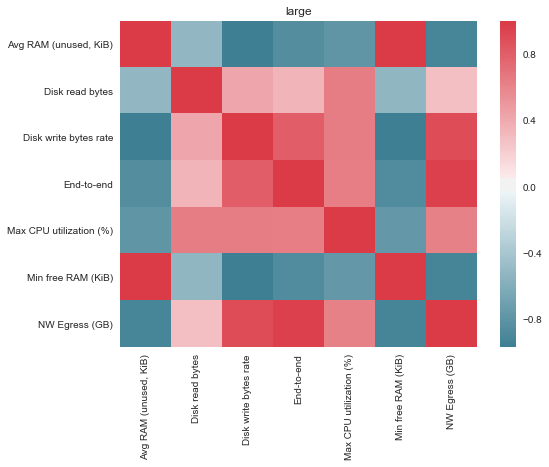

In [2]:
from matplotlib.backends.backend_pdf import PdfPages

writer_report = pd.ExcelWriter(report_directory + "/" + mode + '_report.xlsx', engine='xlsxwriter')

with PdfPages(report_directory + "/" + mode + '_graphs_correlogram.pdf') as pdf:
    metrics = working_metrics
    # correlation matrix visuals 1
    f, ax = plt.subplots(figsize=(8, 6))

    # methods: {‘pearson’, ‘kendall’, ‘spearman’}
    corr = metrics.corr(method='pearson')
    sns_plot = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True))
    ax.set_title(working_metrics_label)
    #plt.savefig(prefix + "_corr.png",  bbox_inches = 'tight')
    pdf.savefig(bbox_inches = 'tight')
    plt.show()
    plt.close()
    # output of parameters
    prefix = working_metrics_label
    metrics.describe().to_excel(writer_report, sheet_name = prefix + "_description")
    metrics.corr().to_excel(writer_report, sheet_name = prefix + "_corr")
    metrics.cov().to_excel(writer_report, sheet_name = prefix + "_cov")
    writer_report.save()
    writer_report.close()

## Scattered distribution plot

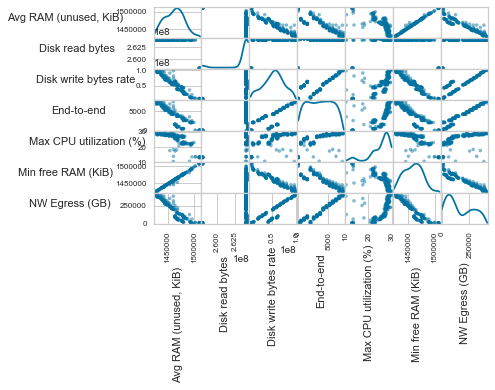

In [3]:
from pandas import plotting

features_to_show = working_metrics.columns

scatter_matrix = plotting.scatter_matrix(metrics[features_to_show], diagonal='kde')   
for x in range(len(features_to_show)):
    for y in range(len(features_to_show)):
        # to get the axis of subplots
        ax = scatter_matrix[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50
plt.show()



# Feature selection

## VIF 

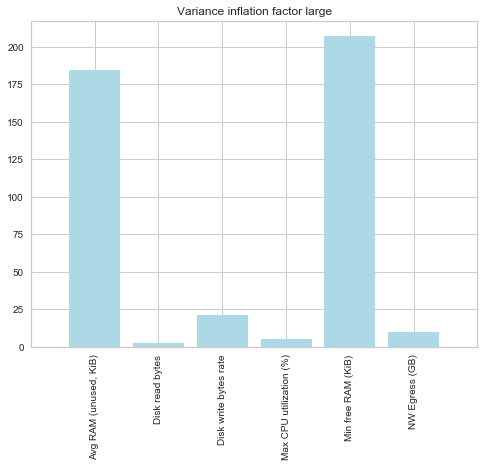

,index,VIF
4,Min free RAM (KiB),206.936653
0,"Avg RAM (unused, KiB)",184.584530
2,Disk write bytes rate,21.438146
5,NW Egress (GB),9.967834
3,Max CPU utilization (%),5.188663
1,Disk read bytes,2.717859


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import cross_validation
metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

vif = [variance_inflation_factor(X_train.values, j) for j in range(X_train.shape[1])]

f, ax = plt.subplots(figsize=(8, 6))
plt.title('Variance inflation factor ' + working_metrics_label)

ax.bar(range(X.shape[1]), vif, color='lightblue', align='center')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

VIF = pd.DataFrame(vif, columns =["VIF"], index=X.columns)
VIF = VIF.reset_index()
VIF.sort_values(['VIF'],ascending=0)

## Variable Importance

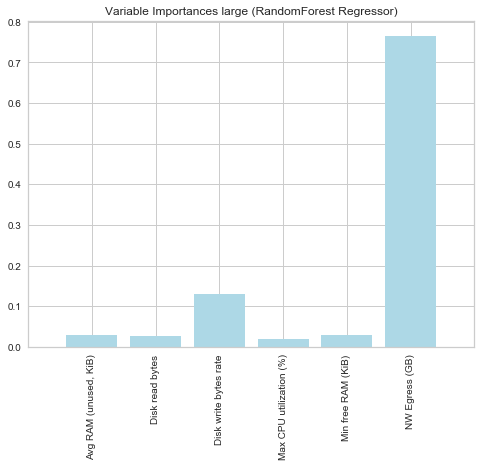

,index,RandomForest
5,NW Egress (GB),0.764726
2,Disk write bytes rate,0.130781
4,Min free RAM (KiB),0.029302
0,"Avg RAM (unused, KiB)",0.028059
1,Disk read bytes,0.026798
3,Max CPU utilization (%),0.020334


In [5]:
from sklearn.ensemble import RandomForestRegressor

X,Y = dataManager.getXY_panda(working_metrics)
model = RandomForestRegressor(n_estimators=200, random_state=1)
model.fit(X, Y)
importances = model.feature_importances_

f, ax = plt.subplots(figsize=(8, 6))
plt.title('Variable Importances ' + working_metrics_label + ' (RandomForest Regressor)')

ax.bar(range(X.shape[1]), importances, color='lightblue', align='center')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

VI = pd.DataFrame(model.feature_importances_, columns = ["RandomForest"], index=X.columns)
VI = VI.reset_index()
VI.sort_values(['RandomForest'],ascending=0)

## Recursive Feature Elimination

In [6]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

X,Y = dataManager.getXY_panda(working_metrics)
model = LinearRegression()
rfe = RFE(model, 20)
fit = rfe.fit(X, Y)

Selected = pd.DataFrame(rfe.support_, columns = ["RFE"], index=X.columns)
Selected = Selected.reset_index()
Selected

,index,RFE
0,"Avg RAM (unused, KiB)",True
1,Disk read bytes,True
2,Disk write bytes rate,True
3,Max CPU utilization (%),True
4,Min free RAM (KiB),True
5,NW Egress (GB),True


## Variable Importance - Extratrees Regressor

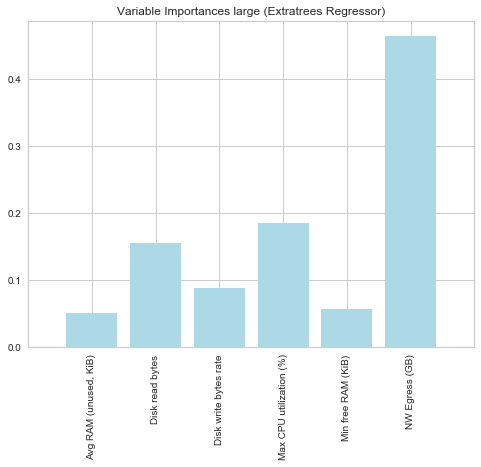

,index,Extratrees
5,NW Egress (GB),0.464014
3,Max CPU utilization (%),0.185626
1,Disk read bytes,0.154955
2,Disk write bytes rate,0.088293
4,Min free RAM (KiB),0.056243
0,"Avg RAM (unused, KiB)",0.050869


In [7]:
from sklearn.ensemble import ExtraTreesRegressor

X,Y = dataManager.getXY_panda(working_metrics)

model = ExtraTreesRegressor()
model.fit(X, Y)

importances = model.feature_importances_

f, ax = plt.subplots(figsize=(8, 6))
plt.title('Variable Importances ' + working_metrics_label + ' (Extratrees Regressor)')

ax.bar(range(X.shape[1]), importances, color='lightblue', align='center')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

FI = pd.DataFrame(model.feature_importances_, columns = ["Extratrees"], index=X.columns)
FI = FI.reset_index()
FI.sort_values(['Extratrees'],ascending=0)

## L1 feature selection 

In [8]:
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel

X,Y = dataManager.getXY_panda(working_metrics)

lsvr = LinearSVR(random_state=0).fit(X, Y)
model = SelectFromModel(lsvr,prefit=True)
l1 = pd.DataFrame(model.get_support(), columns = ["L1"], index=X.columns)
l1 = l1.reset_index()
l1

,index,L1
0,"Avg RAM (unused, KiB)",False
1,Disk read bytes,False
2,Disk write bytes rate,True
3,Max CPU utilization (%),False
4,Min free RAM (KiB),False
5,NW Egress (GB),True


## Feature selection combined

In [9]:
from functools import reduce
dfs = [VIF, VI, Selected, FI, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)
final_results

,index,VIF,RandomForest,RFE,Extratrees,L1
0,"Avg RAM (unused, KiB)",184.584530,0.028059,True,0.050869,False
1,Disk read bytes,2.717859,0.026798,True,0.154955,False
2,Disk write bytes rate,21.438146,0.130781,True,0.088293,True
3,Max CPU utilization (%),5.188663,0.020334,True,0.185626,False
4,Min free RAM (KiB),206.936653,0.029302,True,0.056243,False
5,NW Egress (GB),9.967834,0.764726,True,0.464014,True
